# Create simple label dataset

In [1]:
import glob
import numpy as np
import tables as tb
import pandas as pd

from invisible_cities.io.dst_io import load_dst
import matplotlib.pyplot as plt

In [2]:
basedir = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/'
pressures = ['1bar', '2bar', '5bar', '13bar']
data_type = ['0nubb', '1eroi']

nexusfiles, labelfiles, graphfiles = {}, {}, {}

for dt in data_type:
    for p in pressures:
        nexusdir = basedir + '{p}/{dt}/nexus/*_{dt}.h5'.format(p = p, dt = dt)
        labeldir = basedir + '{p}/{dt}/label/prod/*_{dt}.h5'.format(p = p, dt = dt)
        graphdir = basedir + '{p}/{dt}/label/prod/*_{dt}_graph.h5'.format(p = p, dt = dt)

        nexusfiles[p + '/' + dt] = sorted(glob.glob(nexusdir), key = lambda x: int(x.split('/')[-1].split('_')[-2]))
        labelfiles[p + '/' + dt] = sorted(glob.glob(labeldir), key = lambda x: int(x.split('/')[-1].split('_')[-2]))
        graphfiles[p + '/' + dt] = sorted(glob.glob(graphdir), key = lambda x: int(x.split('/')[-1].split('_')[-3]))

In [3]:
def get_extremes(labelhits):
    bincl = labelhits.binclass.unique()
    assert len(bincl) == 1, 'There are hits of background and signal in the same dataset'
    labelhits['segclass'] = labelhits['segclass'].replace(3, 2)

    track_hits = labelhits[labelhits.segclass == 2]

    #I use ext2 as the start of the track because for bkg it will always be the blob2; for signal
    if bincl == 0:
        ext2 = track_hits.groupby(['dataset_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmin()])[['x', 'y', 'z']].values
        ext1 = track_hits.groupby(['dataset_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmax()])[['x', 'y', 'z']].values

    if bincl == 1:
        track_ends  = track_hits.groupby(['dataset_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmax()])
        ext2 = track_ends[track_ends.particle_id == 1][['x', 'y', 'z']].values
        ext1 = track_ends[track_ends.particle_id == 2][['x', 'y', 'z']].values
    
    return ext1, ext2

def get_bins(*args, min_size = (-500, -500, 0), max_size = (500, 500, 1300), nbins = (501, 501, 651)):
    bins_x = np.linspace(min_size[0], max_size[0], nbins[0])
    bins_y = np.linspace(min_size[1], max_size[1], nbins[1])
    bins_z = np.linspace(min_size[2], max_size[2], nbins[2])
    bins = (bins_x, bins_y, bins_z)
    return bins

def get_ext_flag(f):
    hits = pd.read_hdf(f, 'DATASET/MCHits')
    ext1, ext2 = get_extremes(hits)
    ext_df = pd.DataFrame({'dataset_id':hits.dataset_id.unique(), 'ext1':list(ext1), 'ext2':list(ext2)})

    bins = get_bins()
    voxelizer = lambda x: [np.histogram(x[i], bins[i])[0].nonzero()[0][0] for i in range(len(x))]
    ext_df.ext1 = ext_df.ext1.apply(voxelizer)
    ext_df.ext2 = ext_df.ext2.apply(voxelizer)
    ext_df = pd.melt(ext_df, id_vars='dataset_id', value_vars = ['ext1', 'ext2'], var_name = 'ext', value_name='voxel')#.sorted(['dataset_id'])
    ext_df[['x', 'y', 'z']] = ext_df.voxel.apply(pd.Series)
    ext_df.ext = ext_df.ext.apply(lambda x: int(x[-1]) if type(x) == str else int(x))
    return ext_df

def create_dataset_df(voxels, filenum, cols = ['dataset_id', 'x', 'y', 'z', 'ener', 'binclass', 'segclass', 'cloud', 'nhits', 'ext'], rename = {'dataset_id':'event', 'ener':'E', 'cloud':'track_id'}):
    df = voxels[cols].rename(columns = rename)
    df.insert(0, 'file_id', filenum)
    df['track_id'] = df['track_id'].apply(lambda x: int(x.split('_')[-1]))
    df['segclass'] = df['segclass'].apply(lambda x: int(x - 1))
    # to avoid the different int classes
    df['nhits'] = df['nhits'].astype('int16')
    return df

def create_dataset_file(file_dict, basedir):
    for name in file_dict:
        print(name)
        savedir = basedir.format(name, name.replace('/', '_'))
        for f in file_dict[name]:
            filenum = int(f.split('/')[-1].split('_')[-2])
            vox = pd.read_hdf(f, 'DATASET/MCVoxels')
            ext_df = get_ext_flag(f)
            vox_ext = vox.merge(ext_df.drop('voxel', axis = 1), on = ['dataset_id', 'x', 'y', 'z'], how = 'outer').fillna(0)
            vox_ext.ext = vox_ext.ext.astype(int)

            df = create_dataset_df(vox_ext, filenum)
            df.to_hdf(savedir, 'voxels', append = True)

        pd.read_hdf(f, 'DATASET/BinsInfo').to_hdf(savedir, 'bins')

In [4]:
savedir = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/{}/label/voxel_dataset_{}.h5'

# create_dataset_file(labelfiles, savedir)

In [8]:
vox_1eroi_13bar = pd.read_hdf(savedir.format('13bar/1eroi', '13bar_1eroi'), 'voxels')
vox_0nubb_13bar = pd.read_hdf(savedir.format('13bar/0nubb', '13bar_0nubb'), 'voxels')

### Transformar coordenadas a espacio

In [18]:
def transform_coords(df, inf, coords = ['x', 'y', 'z']):
    for coord in coords:
        min_, max_, size = inf['min_' + coord].values[0], inf['max_' + coord].values[0], inf['size_' + coord].values[0]
        bins = np.arange(min_, max_ + size, size)
        df[coord] = df[coord].apply(lambda x: bins[x])
    return df

### Codigo nuevo para añadir la info de extremos sobre ficheros ya creados. No lo volveré a usar supongo porque ya lo añadí al original, pero no lo borro por ahora

In [ ]:
# #info de bins que ya tenemos obviamente
# bins_x = np.linspace(-500, 500, 501)
# bins_y = np.linspace(-500, 500, 501)
# bins_z = np.linspace(0, 1300, 651)
# bins = (bins_x, bins_y, bins_z)

# voxelizer = lambda x: [np.histogram(x[i], bins[i])[0].nonzero()[0][0] for i in range(len(x))]

# savedir = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/{}/label/voxel_dataset_{}.h5'

# #la info de extremos la tenemos en un fichero completa, separada por dt. 
# #Lo lógico es q primero se haga para 1 dt con todas las presiones, y luego para otro dt
# for dt in data_type:
#     print(dt)
#     extreme_info = pd.read_hdf(basedir + 'track_blobrad_info_df.h5', dt)
#     extreme_info = extreme_info[['pressure', 'dataset_id', 'filenum', 'ext1', 'ext2']]
#     extreme_info.ext1 = extreme_info.ext1.apply(voxelizer)
#     extreme_info.ext2 = extreme_info.ext2.apply(voxelizer)
#     extreme_info = pd.melt(extreme_info, id_vars=['pressure', 'dataset_id', 'filenum'], value_vars = ['ext1', 'ext2'], var_name = 'ext', value_name='voxel')
#     extreme_info[['x', 'y', 'z']] = extreme_info.voxel.apply(pd.Series)
#     extreme_info.ext = extreme_info.ext.apply(lambda x: int(x[-1]) if type(x) == str else int(x))

#     #aqui loop en p
#     for p in pressures:
#         print(p)
#         name = p + '/' + dt
#         orig_file = savedir.format(name, name.replace('/', '_'))
#         new_file = savedir.format(name, name.replace('/', '_') + '_ext')
#         ext_inf = extreme_info[extreme_info.pressure == p][['dataset_id', 'filenum', 'ext', 'x', 'y', 'z']].rename(columns={'dataset_id':'event', 'filenum':'file_id'})

#         dataset_df = pd.read_hdf(orig_file, 'voxels')
#         merged_dataset_df = dataset_df.merge(ext_inf, on = ['event', 'file_id', 'x', 'y', 'z'], how = 'outer').fillna(0)
#         merged_dataset_df.to_hdf(new_file, 'voxels')

#         pd.read_hdf(orig_file, 'bins').to_hdf(new_file, 'bins')


0nubb
1bar
2bar
5bar
13bar
1eroi
1bar
2bar
5bar
13bar


mirar plots de info de los extremos a ver como se distribuyen para cada presion, que energía, etc :)

1bar/0nubb


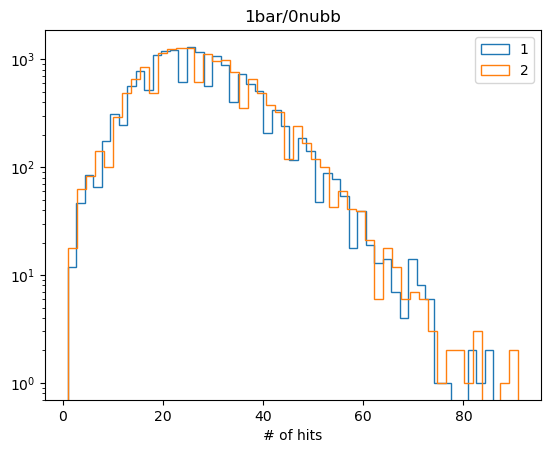

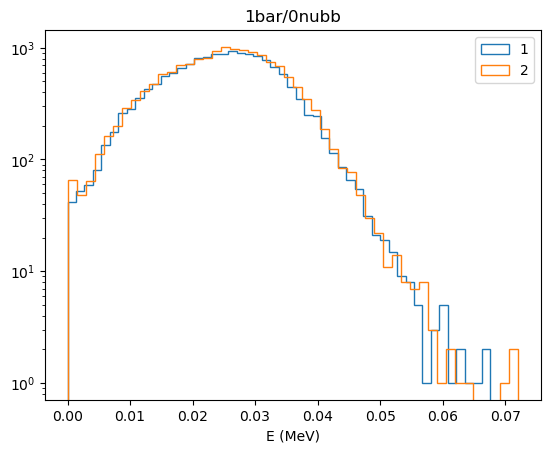

2bar/0nubb


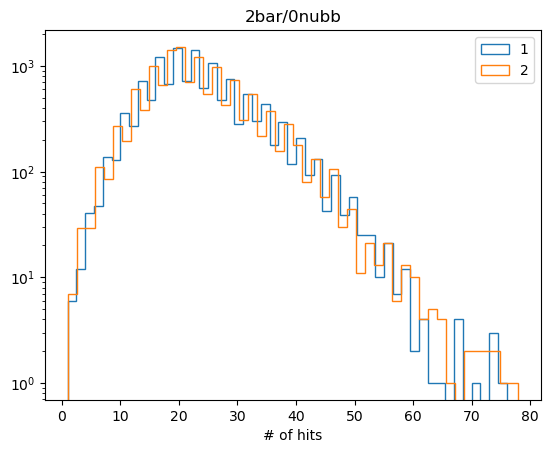

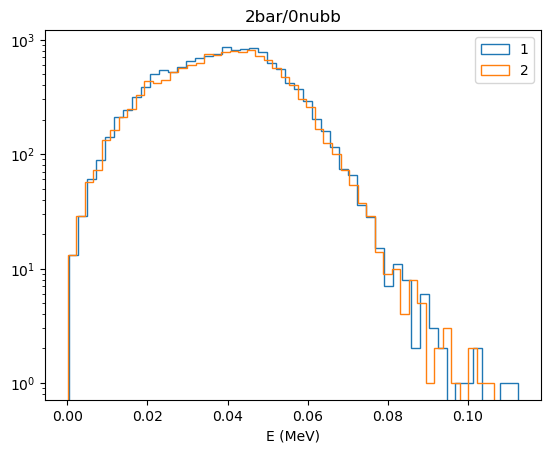

5bar/0nubb


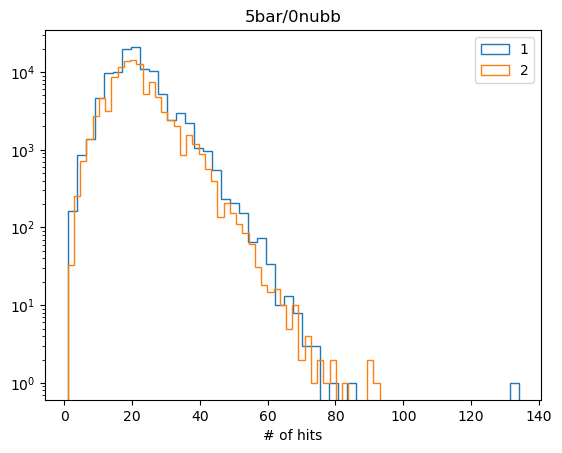

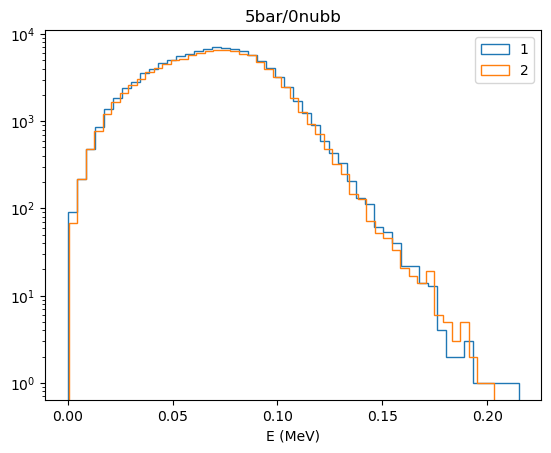

13bar/0nubb


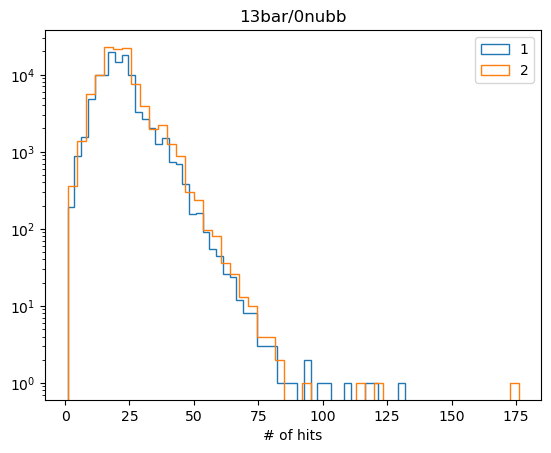

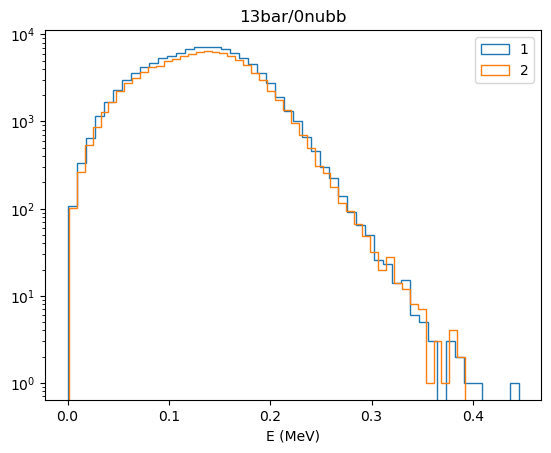

1bar/1eroi


: 

: 

: 

In [112]:
for name in labelfiles:
    print(name)
    df = pd.read_hdf(savedir.format(name, name.replace('/', '_') + '_final'), 'voxels')
    extremes = df[df.ext != 0]

    ext1_vox = extremes[extremes.ext == 1]
    ext2_vox = extremes[extremes.ext == 2]

    plt.hist(ext1_vox.nhits, 50, histtype = 'step', label = 1)#, (0, 100))
    plt.hist(ext2_vox.nhits, 50, histtype = 'step', label = 2)#, (0, 100))
    plt.yscale('log')
    plt.legend()
    plt.xlabel('# of hits')
    plt.title(name)
    plt.show()

    plt.hist(ext1_vox.E, 50, histtype = 'step', label = 1)#, (0, 100))
    plt.hist(ext2_vox.E, 50, histtype = 'step', label = 2)#, (0, 100))
    plt.yscale('log')
    plt.legend()
    plt.xlabel('E (MeV)')
    plt.title(name)
    plt.show()